# Auteur : PAMBOU MOUBOGHA Eddy Vianney
# Etudes : Master Sciences des Donnees et Systèmes Complexes
# Ecole : Université de Strasbourg
# Sujet :  Detection de glissements de terrain

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from datetime import date, datetime
import datetime
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import multiprocessing
import itertools
import operator
import math
from dtaidistance import dtw
import seaborn as sns
plt.style.use('fivethirtyeight')

# Attributs des fichiers MM_TIO

* Lat : latitude (degré)
* Lon : longitude (degré)
* Vel : vitesse (mètre/jour)
* Topo : altitude d'un point (mètre)
* TS : serie temporelles de déplacement (mètre)

In [6]:
DATA_PATH = './donnees'

# Paramètres des géométries ascendante et descendante

In [2]:
# angle d'incidence du satellite en géométrie ascendante (angle entre la vertical et la direction du  satellite)
theta_asc = 0
# angle d'incidence du satelitte en géométrie descendante (angle entre la vertical et la direction du satellite)
theta_desc = 0
# difference angulaire des orbites des géométries ascendante et descendante
delta_alpha =  0
# déplacement le long de la ligne de visée en géométrie ascendante
d_los_asc = 0
# déplacement le long de la ligne de visée en géométrie descendante
d_los_dsc = 0
# # déplacement vertical
d_up = 0

# Chargement des données

In [15]:
def to_date(str):
    str_strp = str.strip()
    year, month, day = int(str_strp[0:4]), int(str_strp[4:6]), int(str_strp[6:8])
    return date(year, month, day)

def load_data(filename):

    # numéro de la ligne ou commence les données
    num_start = 44
    # numéro de la ligne ou se trouve la liste des dates
    num_list_dates = 40
    # attributs présent dans les données
    columns = ['id', 'Lat','Lon', 'Topo', 'Vel', 'Coer',' CosN', 'CosE', 'CosU']
    # dictionnaire stockant les données
    data = {column: [] for column in columns}
    # liste des dates 
    indexes = []
    # series temporelles
    series = []
    # liste de dataframes
    df_series = []

    with open(DATA_PATH + '/' + filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 1 
        for row in csv_reader:
            if line_count == num_list_dates:
                indexes = [row[0].split(' ')[1]] + row[1:]
            if line_count >= num_start:
                # extraction des premiers attributs
                for i in range(len(columns)):
                    data[columns[i]].append(row[i])
                # extraction de l'attribut TS(série temporelle)
                series.append([float(v) for v in row[len(columns):]])
            line_count  += 1
        if len(indexes) != len(series[0]):
            print('Erreur : Les indexes et les valeurs ne correspondent pas')
        # convertir les index en date
        indexes = [d.strip()[0:8] for d in indexes]
        # créer une liste de dataframes, chacun contenant une série temporelle
        for serie in series:
            tmp_serie = pd.DataFrame({'displacement': pd.Series(serie, index=pd.DatetimeIndex(indexes))})
            tmp_serie.sort_index(inplace=True)
            df_series.append(tmp_serie)
        # creer un dataframe pour les autres attributs
        df = pd.DataFrame(data)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        df.set_index('id')
        
    return df, df_series

# imputer les données
def impute(ns_series, ew_series, pc=0.4):

    # nombre de mésures
    n = len(ns_series[0])
    
    # recupérer les series de la composante Nord-Sud qui ont un pourcentage de valeurs manquuantes inferieur à 50%
    ns_booleans  = [True if (ns_series[i].isnull().sum().sum()/n) < pc else False for i in range(len(ns_series))]
    # recupérer les series de la composante Est-Ouest qui ont un pourcentage de valeurs manquuantes inferieur à 50%
    ew_booleans  = [True if (ew_series[i].isnull().sum().sum()/n) < pc else False for i in range(len(ew_series))]
    # Conserver uniquement les points où la norme du vecteur vitesse est calculable
    booleans     = [True if i and j else False for i, j in zip(ns_booleans, ew_booleans)]
    
    # suppression des séries temporelles qui ont un pourcentage de valeurs manquantes supérieure ou égale à 0.5
    ns_series_c = [d for d in itertools.compress(ns_series, booleans)]
    ew_series_c = [d for d in itertools.compress(ew_series, booleans)]
    
    # interpoler les valeurs manquantes des les séries restantes
    for i in range(len(ns_series_c)):
        if ns_series_c[i].isnull().sum().sum() > 0:
            ns_series_c[i].interpolate(limit_direction='both', inplace=True)
        if ew_series_c[i].isnull().sum().sum() > 0:
            ew_series_c[i].interpolate(limit_direction='both', inplace=True)
            
    return ns_series_c[0].index, ew_series_c, ns_series_c

In [16]:
# chargement de la composante  Est-Ouest du mouvement du sol
df_ew, df_ew_ts = load_data('MM_TIO_EW_31TGK_20151227_to_20200906.csv')
# chargement de la composante Nord-Sud du mouvement du sol
df_ns, df_ns_ts = load_data('MM_TIO_NS_31TGK_20151227_to_20200906.csv')

In [ ]:
# fusion des deux composantes 


# Visualisation 

In [12]:
#from datetime import datetime
Y = 2000
seasons  = [('winter', date(Y,  1,  1), date(Y,  3, 20)),
           ('spring', date(Y,  3, 21),  date(Y,  6, 20)),
           ('summer', date(Y,  6, 21),  date(Y,  9, 22)),
           ('autumn', date(Y,  9, 23),  date(Y, 12, 20)),
           ('winter', date(Y, 12, 21),  date(Y, 12, 31))]


def get_season(date):
    
    for season in seasons:
        name  = season[0]
        start = season[1].replace(year=date.year)
        end   = season[2].replace(year=date.year)
        if start <= date <= end:
            return name
        
def count_samples_per_season(dates):
    
    samples_per_season = {'winter': 0, 'spring': 0, 'summer': 0, 'autumn': 0}
    for date in dates:
        samples_per_season[get_season(date)] += 1
        
    return samples_per_season

def plot_pie(labels, values):

    fig1, ax1 = plt.subplots(figsize=(5,5))
    ax1.pie(values, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal') 

    plt.show()
    
def get_days(dates):
    days = []
    for i in range(len(dates)):
        days.append(abs((dates[0] - dates[i]).days ))
    return days

def plot_displacement(ns_ts, ew_ts):
    
    days = get_days(ns_ts.index)
    fig, ax = plt.subplots(figsize=(15,5))
    
    ax.plot(ns_ts['displacement'], color='blue', label='NS displacement (m)', marker='o', linewidth=2)
    ax.plot(ew_ts['displacement'], color='orange', label='EW displacement (m)', marker='o', linewidth=2)
    
    plt.legend(loc='best')
    
def plot_displacement_velocity(ns_ts, ew_ts):

    days = get_days(ns_ts[0].index)

    fig, ax_left = plt.subplots(figsize=(15,5))
    ax_right = ax_left.twinx()

    p1, = ax_left.plot(days, df_series[4]['displacement'], color='blue', label='NS displacement (m)')
    p2, = ax_right.plot(days, df_series[4]['displacement'], color='orange', label='EW displacement(m)')

    ax_left.set_xlabel("number of days since the first measure")
    ax_left.set_ylabel("displacement")
    ax_right.set_ylabel("velocity")

    lns = [p1, p2]

    ax_left.legend(handles=lns, loc='best')
    fig.tight_layout()
    plt.show()

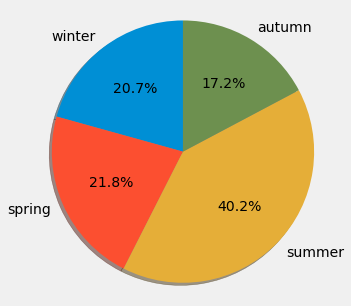

In [103]:
r = count_samples_per_season(df_ew_ts[0].index)
plot_pie(list(r.keys()), list(r.values()))

In [14]:
# c is the attribute we'll map onto colors, s is the attribute we'll represent with circle size.
df_ns.plot(kind="scatter", x="Lat", y="Lon",
    s=df_ns['Topo']/1000, label="Elevation (m)",
    c="Vel", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
plt.show()

NameError: name 'df_ns' is not defined

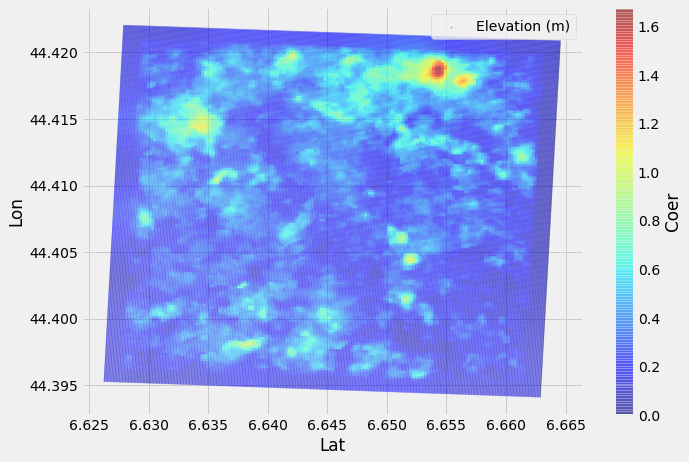

In [853]:
# c is the attribute we'll map onto colors, s is the attribute we'll represent with circle size.
df_ns.plot(kind="scatter", x="Lat", y="Lon",
    s=df_ns['Topo']/1000, label="Elevation (m)",
    c="Coer", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
plt.show()

# Nettoyage des données et détection d'anomalies

In [17]:
# imputer les valeurs manquantes
indexes, ew_ts, ns_ts = impute(df_ew_ts, df_ns_ts)

# Calcul de vitesses à partir des composantes Nord-Sud et Est-Ouest du mouvement

In [19]:
def compute_inst_vel(serie):
    
    vels = []
    
    for j in range(1, len(serie)-1):
        duration = (serie.index[j+1] - serie.index[j-1]).days
        displacement = serie.iloc[j+1]['displacement'] - serie.iloc[j-1]['displacement']
        vels.append(displacement / duration)
    # supprimer le premier et le dernier index (formule non applicable)
    return pd.DataFrame(vels, index=serie.index[1:-1], columns=['vel'])
    
def compute_velocity(ns_component, ew_component):
    return math.sqrt(ns_component*ns_component + ew_component*ew_component)

# créer les séries temporelles de vitesse instantanée
def compute_magnitude(ns_vel_ts, ew_vel_ts):
    
    magnitudes = []
    indexes = ns_vel_ts[0].index
    
    for i in range(len(ns_vel_ts)):
        vels = []
        for ns_component, ew_component in zip(ns_vel_ts[i]['vel'], ew_vel_ts[i]['vel']):
            vels.append(compute_velocity(ns_component, ew_component))
        df = pd.DataFrame(vels, index=indexes, columns=['magnitude'])
        magnitudes.append(df)
        
    return magnitudes

In [178]:
n_cores = multiprocessing.cpu_count()

def compute_inst_vels(series, n_cores=n_cores):
    
    with multiprocessing.Pool(n_cores) as p:
        results = p.map(compute_inst_vel , series)
        return results

In [21]:
# calcul des vitesses instantanées sur chaque composante
#ns_vel_ts = compute_inst_vels(ns_ts)
#ew_vel_ts = compute_inst_vels(ew_ts)

# calcul de la magnitude du vecteur vitesse instantanée
#magnitude_ts = compute_magnitude(ns_vel_ts, ew_vel_ts)

In [15]:
plot_series(magnitude_ts)

NameError: name 'plot_series' is not defined

In [190]:
# calculer la vitesse instantanée sur chaque composante
# calculer le module de la vitesse 

# Calcul de la vitesse instannée

In [252]:
def get_days(dates):
    days = []
    for i in range(len(df_series[0])):
        days.append(abs((dates[0] - dates[i]).days ))
    return days
 
def plot_displacement_velocity(ns_ts, ew_ts, vels):


    fig, (ax_left, ax) = plt.subplots(2, figsize=(15,15))
    ax_right = ax_left.twinx()

    p1, = ax_left.plot(ns_ts['displacement'], color='blue', label='displacement (m)', marker='o', linewidth=2)
    p2, = ax_left.plot(ew_ts['displacement'], color='orange', label='displacement (m)', marker='s', linewidth=2)
    p3, = ax_right.plot(vels['magnitude'], color='green', label='velocity (m/day)', marker='d', linewidth=2)

    ax_left.set_xlabel("dates")
    ax_left.set_ylabel("displacement")
    ax_right.set_ylabel("velocity")

    lns = [p1, p2, p3]
    
    ax_left.legend(handles=lns, loc='best')
    fig.tight_layout()
    plt.show()

def plot_disp_vel(ns_ts, ew_ts, vels):
    
    fig, ax = plt.subplots(3, 1, figsize=(15,10))
    
    min1, max1  = int(ns_ts['displacement'].min()) - 1, int(ns_ts['displacement'].max()) + 1
    min2, max2  = int(ew_ts['displacement'].min()) - 1, int(ew_ts['displacement'].max()) + 1

    ax[0].plot(ns_ts['displacement'], color='blue', label='displacement (m)', marker='o', linewidth=2)
    ax[0].set_title('NS cumulative displacement')
    ax[0].set_xlabel('time')
    ax[0].set_ylabel('displacement')
    #ax[0].set_ylim([])
    ax[0].legend()
    
    ax[1].plot(ew_ts['displacement'], color='orange', label='displacement (m)', marker='o', linewidth=2)
    ax[1].set_title('EW cumulative displacement')
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('displacement')
    ax[1].legend()
    
    ax[2].plot(vels['magnitude'], color='green', label='velocity (m/day)', marker='o', linewidth=2)
    ax[2].set_title('Velocity magnitude')
    ax[2].set_xlabel('time')
    ax[2].set_ylabel('velocity')
    ax[2].legend()
    
    fig.tight_layout()
    plt.show()
    

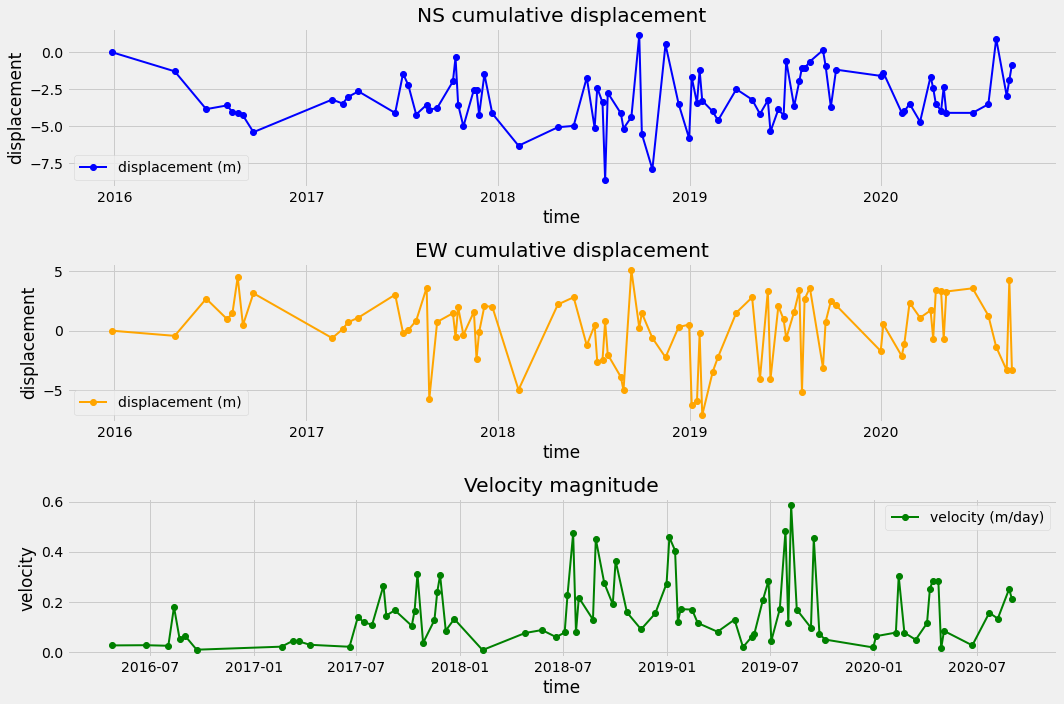

In [300]:
n = 87000
plot_disp_vel(ns_ts[n], ew_ts[n], magnitude_ts[n])

In [302]:
adf_result = adfuller(ns_ts[n])
adf_output = pd.Series(adf_result[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in adf_result[4].items():
  adf_output['Critical Value (%s)'%(key)] = value
print(adf_output)

Test Statistic                 -3.793153
p-value                         0.002978
#Lags Used                      2.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


## ST-DBSCAN

{2: 2971, -1: 29}

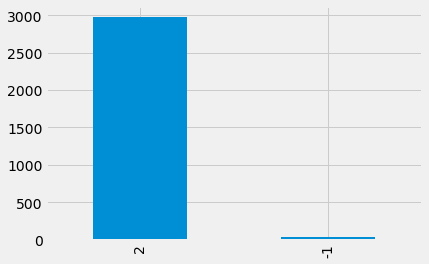

In [112]:
labels = clusterer.labels_
plot_distribution(labels)

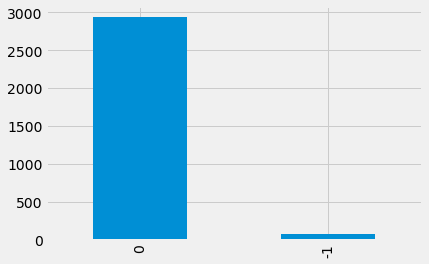

In [292]:
series = plot_distribution(clusterer.labels_)

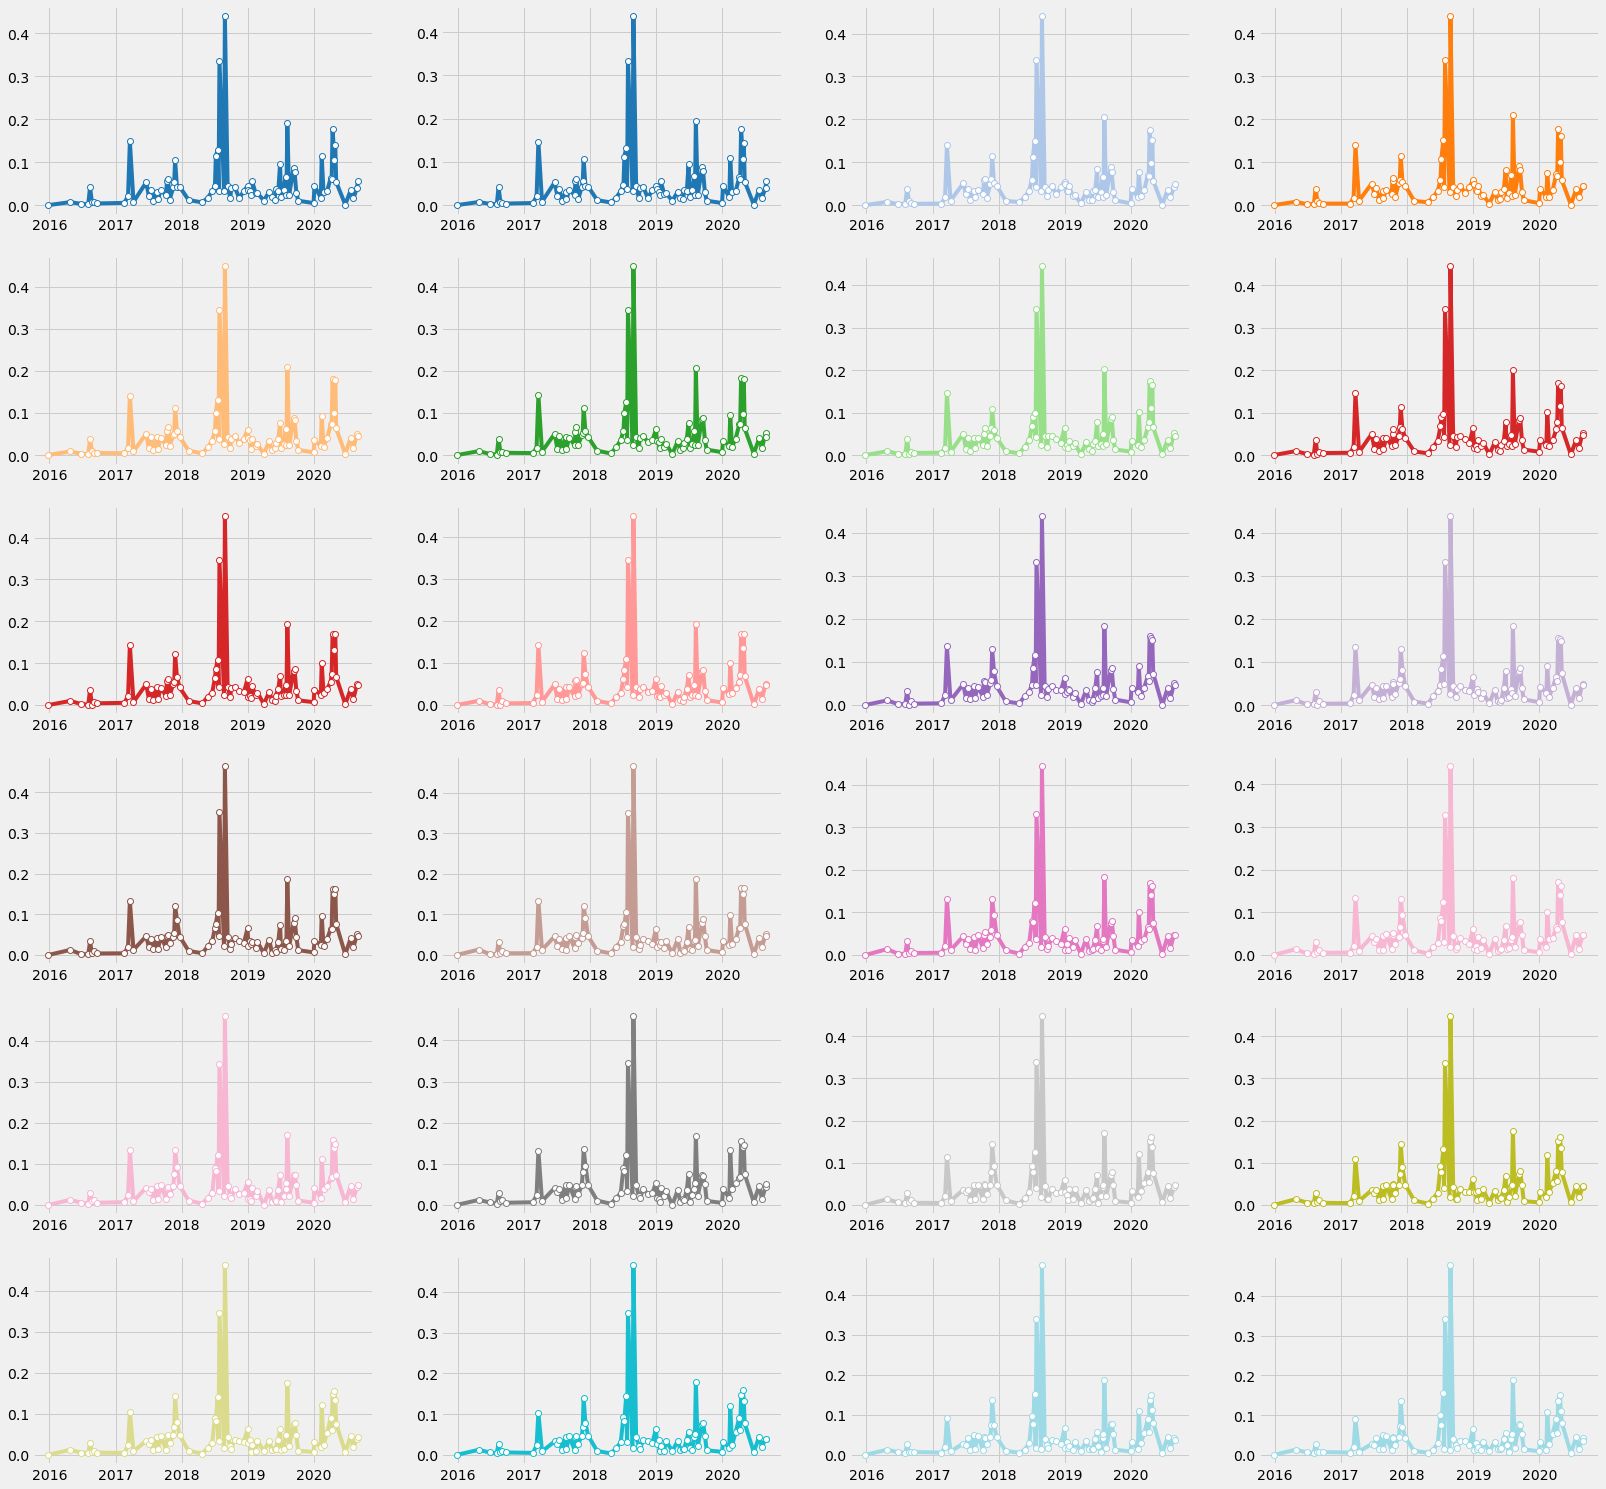

In [295]:
plot_series(get_data_from_class(vel_ts, clusterer.labels_, 2))

In [ ]:
def plot_distribution(liste):
    
    v_count = dict()
    
    for i in liste:
        if liste[i] in v_count:
            v_count[liste[i]] += 1
        else:
            v_count[liste[i]] = 1
            
    pd.Series(v_count).plot(kind='bar')
    
    return v_count
    
def get_data_from_class(series, labels, num_label):
    
    data = []
    
    for i in range(len(labels)):
        if labels[i] == num_label:
            data.append(series[i])
            
    return data

In [ ]:
#projection = TSNE().fit_transform(X)

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True).fit(X)

color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.show()

In [664]:
from sklearn.manifold import TSNE
import hdbscan

## HDBSCAN

In [197]:
def plot_kmeans_clusters_shape(data, km, n_cols=3):
    
    n_rows = int(km.n_clusters / n_cols) if km.n_clusters % n_cols == 0 else int(math.ceil(km.n_clusters / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(25,15))

    for num_cluster in range(km.n_clusters):
        for serie_index in range(len(data)):
            if km.labels_[serie_index] == num_cluster:
                axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(data[serie_index], c="gray", alpha=0.2)

        axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(km.cluster_centers_[num_cluster].ravel(), "r-")
        axs[int(num_cluster / n_cols), num_cluster % n_cols].set_title('Cluster %d'%(num_cluster + 1))
        

## Kmeans

In [ ]:
distances = compute_distances_matrix(vel_ts)

In [662]:
X = normalize(magnitude_ts)

In [17]:
def normalize(series):
    
    output = []
    
    for serie in series:
        serie = serie.dropna(inplace=False)
        serie  = StandardScaler().fit_transform(serie)
        serie  = serie.reshape(len(serie))
        output.append(serie)
        
    return np.array(output)

def compute_distances_matrix(series):
    
    # initialisation de la matrix des distances
    distances_matrix = np.zeros(shape=(len(series), len(series)))
    
    # calcul des distances et remplissage de la matrice de distance
    for n in range(len(series)):
        for m in range(len(series)):
            x = series[n]['velocity'].dropna(inplace=False)
            y = series[m]['velocity'].dropna(inplace=False)
            dist = dtw.distance(x, y)
            distances_matrix[n, m] = dist
                
    return distances_matrix

Si on ne s'interesse qu'à la forme des séries, il faut normaliser avant d'appliquer le clustering

# Classification des séries temporelles

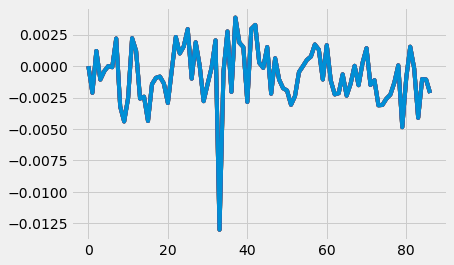

In [72]:
for i in range(len(transformer.components_)):
    plt.plot(transformer.components_[6])

In [61]:
np.dot(transformer.mixing_, transformer.components_[0])

ValueError: shapes (87,20) and (87,) not aligned: 20 (dim 1) != 87 (dim 0)

In [66]:
transformer.components_.shape

(20, 87)

In [81]:
# recherchons une source
# S = WX
transformer.components_.shape #(20, 87)
# calculons l'activité d'une source
source = np.dot(X, transformer.components_[0])
# passage de S à X
np.dot(transformer.mixing_[:,0], source)

ValueError: shapes (87,) and (87016,) not aligned: 87 (dim 0) != 87016 (dim 0)

In [82]:
X_transformed.shape

(87016, 20)

In [65]:
transformer = FastICA(n_components=20, random_state=0)
X_transformed = transformer.fit_transform(X)

In [41]:
X = reshape(ns_ts)

In [32]:
def reshape(series):
    
    result = []
    n = len(series[0])
    
    for i in range(len(series)):
        result.append(series[i].values.reshape(n))
        
    return np.array(result)

In [31]:
X = np.array(ns_ts)

In [30]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA

X, _ = load_digits(return_X_y=True)
transformer = FastICA(n_components=7, random_state=0)
X_transformed = transformer.fit_transform(X)
X_transformed.shape

/home/eost-user/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


(1797, 7)

In [539]:
from sklearn.decomposition import FastICA, PCA

# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [470]:
transformer = FastICA(n_components=3, random_state=0)
X_transformed = transformer.fit_transform(ns_ts[0].values)

/home/eost-user/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:468: UserWarning: n_components is too large: it will be set to 2
  warnings.warn(


## Décomposition en composantes indépendantes

In [ ]:
import statsmodels.api as sm

mod = sm.OLS(Y,X)

fii = mod.fit()

p_values = fii.summary2().tables[1]['P>|t|']

In [10]:
reg = LinearRegression()
reg.fit(df_series[0].index.values.reshape(-1,1), df_series[0]['displacement'].values.reshape(-1,1))

LinearRegression()

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Significativité des régressions linéaires
* p-value : probabilité que la pente soit nulle
* Hypothèse nulle HO : la pente de la droite de regression est nulle  (vitesse moyenne non significative)
* si la p-value est inférieure à 0.05 alors l'hypothèse nulle est rejetée (vitesse moyenne est significative).

In [ ]:
plot_series(non_stationary_series[0:50])

In [137]:
non_stationary_series = []
for i in range(len(non_stationary_index)):
    non_stationary_series.append(df_series[non_stationary_index[i]])

In [ ]:
non_stationary_index = get_non_stationary(df_series)

In [81]:
def impute_time_series(serie):
    if serie.isnull().sum().sum() > 0:
        return serie.interpolate(limit_direction="both",inplace=False)
    else:
        return serie
    
def get_non_stationary(series, alpha=0.05, nb_nan_max=87):
    
    # nombre de series temporelles
    n_series = len(series)
    # liste contenant les indinces des séries temporelles non stationnaires
    non_stationary_series = []
    
    for i in range(len(series)):
        # imputer les series qui ont moins de nb_nan_max valeurs manquantes
        if series[i].isnull().sum().sum() < nb_nan_max: 
            serie = impute_time_series(series[i])
            result = adfuller(serie['displacement'])
            # le test de stationarité échoue automatiquement si la p-value est supérieure à 0.05
            if result[1] > alpha:
                non_stationary_series.append(i)
            
    return non_stationary_series

In [154]:
from statsmodels.tsa.stattools import adfuller

## Test de Dickey-Fuller augmenté (ADF)
La série temporelle est considérée comme stationnaire si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF (Augmented Dickey-Fuller)

# Réechantillonage des données

# Etude de la saisonnalité

In [99]:
num_rows = 6
num_cols = 4

def plot_series(series, num_rows=num_rows, num_cols=num_cols, colormap='tab20'):
plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
    fig, axs = plt.subplots(num_rows,num_cols,figsize=(25,25))
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0,1,num_rows*num_cols)]

    for num_row in range(num_rows):
        for num_col in range(num_cols):
            if num_row*num_cols + num_col < len(series):
                axs[num_row, num_col].plot(series[num_row*num_cols + num_col],color=colors[num_row*num_cols + num_col], marker='o', markerfacecolor='white')
                #axs[num_row, num_col].set_title('serie: %s'%(self.names[num_row*num_cols + num_col].split('.')[0]))

    plt.show()

In [ ]:
import simplekml
kml=simplekml.Kml()
style = simplekml.Style()
style.labelstyle.color = simplekml.Color.red  
style.labelstyle.scale = 2
style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'
for index, row in df.iterrows():
    kml.newpoint(name=row['Vel'], coords=[(row['Lat'], row['Lon'], row['Topo'])])
kml.save('ps.kml')  

In [776]:
y = df_series[0]['deplacement']

fig, ax = plt.subplots(figsize=(15,5))

season_colors = {season : color for (season, color) in zip(('winter', 'spring', 'summer', 'autumn'), ('green', 'purple', 'yellow', 'blue'))}
seasons_count = {season : 0 for season in ('winter', 'spring', 'summer', 'autumn')}
colors  = []
sample_seasons = []

for sample_date in df_series[0].index:
        sample_seasons.append(get_season(sample_date))
for season in sample_seasons:
    colors.append(season_colors[season])

for i in range(len(df_series[0])):
    ax.plot(df_series[0].iloc[0].name, df_series[0].iloc[0].deplacement, 'k', color=colors[i], marker='o')
    
ax.grid()
ax.margins(0)
    
plt.grid()
plt.legend()
plt.show()

NameError: name 'df_series' is not defined

In [264]:
def compute_adfuller_test(serie):
    
    adf_result = adfuller(serie)
    # recuperer la p-value du test
    return adf_result[1]

def compute_adfuller(series, n_cores=n_cores):
    
    with multiprocessing.Pool(n_cores) as p:
        results = p.map(compute_adfuller_test , series)
        return results

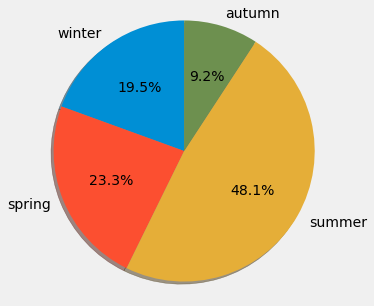

In [97]:
plot_pie(list(spikes.keys()), list(spikes.values()))

In [105]:
spikes

{'winter': 149417, 'spring': 178795, 'summer': 369083, 'autumn': 70776}

In [ ]:
spikes = compute_anomalie_distribution(ns_ts)

In [107]:
# on va rechercher la repartition des pics par saison en utilisant un critère statistique
def compute_anomalie_distribution(series):
    
    spikes = {'winter': 0, 'spring': 0, 'summer': 0, 'autumn': 0}
    
    for i in range(len(series)):
        l = get_spikes(series[i])
        for j in range(len(l)):
            spikes[l[j]] += 1
            
    return spikes

In [111]:
get_spikes(ns_ts[50000])

['summer', 'summer']

In [107]:
def get_spikes(serie):
    
    dates = []
    indexes = []
    sigma = math.sqrt(serie.var())
    
    for i, v in enumerate(serie['displacement']):
        if abs(v) > 2*sigma:
            indexes.append(i)
    
    return [get_season(serie.index[i]) for i in indexes]

In [224]:
adf_result = adfuller(ns_ts[n])
adf_output = pd.Series(adf_result[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in adf_result[4].items():
  adf_output['Critical Value (%s)'%(key)] = value
print(adf_output)

Test Statistic                -8.740216e+00
p-value                        3.023087e-14
#Lags Used                     0.000000e+00
Number of Observations Used    8.600000e+01
Critical Value (1%)           -3.508783e+00
Critical Value (5%)           -2.895784e+00
Critical Value (10%)          -2.585038e+00
dtype: float64


In [192]:
#p_v = compute_adfuller(ns_ts)

KeyboardInterrupt: 

In [175]:
n = 0 
n +=1
n

1

1.0269134961374899e-11


,displacement
2015-12-27,0.0000
2016-04-25,4.0508
2016-06-24,4.6904
2016-08-03,3.4847
2016-08-13,3.1952
...,...
2020-07-23,3.3171
2020-08-07,3.6081
2020-08-27,2.1763
2020-09-01,0.1151


In [106]:
np.fft.fft(ew_ts[n])

array([[  0.    +0.j],
       [ -5.4942+0.j],
       [ -6.2416+0.j],
       [ -5.6465+0.j],
       [ -5.455 +0.j],
       [ -5.785 +0.j],
       [ -5.8648+0.j],
       [ -5.986 +0.j],
       [ -1.4083+0.j],
       [ -3.5675+0.j],
       [ -4.9557+0.j],
       [ -5.6394+0.j],
       [ -6.7146+0.j],
       [ -5.6208+0.j],
       [ -5.7039+0.j],
       [ -5.0665+0.j],
       [ -6.5502+0.j],
       [ -5.6924+0.j],
       [ -5.5902+0.j],
       [ -4.5263+0.j],
       [ -4.2327+0.j],
       [ -4.0185+0.j],
       [ -3.4041+0.j],
       [ -1.383 +0.j],
       [  0.3227+0.j],
       [  1.0533+0.j],
       [  0.3729+0.j],
       [ -1.661 +0.j],
       [ -5.4479+0.j],
       [ -6.4752+0.j],
       [ -5.0472+0.j],
       [ -5.1526+0.j],
       [ -6.6143+0.j],
       [ -6.3841+0.j],
       [ -5.6994+0.j],
       [ -6.1533+0.j],
       [ -5.3302+0.j],
       [-11.5466+0.j],
       [ -4.7664+0.j],
       [ -6.065 +0.j],
       [ -4.7234+0.j],
       [ -5.189 +0.j],
       [ -4.5219+0.j],
       [ -1

In [69]:
transformer.components_[0].shape

(87,)

In [44]:
X.shape

(87016, 87)

In [82]:
r

{'winter': 18, 'spring': 19, 'summer': 35, 'autumn': 15}